# Agarose phantom analysis

We want to demonstrate phase-contrast OPT

Using an agarose phantom (one cylinder embedded inside another, with different refractive indices)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
from scipy import ndimage
import cv2
from tqdm import tqdm

## Reading in the images

In [2]:
# filepath on Predator machine
img_dir = r'D:\MSci_Project\1_Data\2023-03-17'
phantom = io.imread(img_dir + r'\2023-03-17 phase gradient phantom fullstack.tif')

# filepath on mac
# img_dir = '../../OPT Shared files/1_Data/2023-03-17/'
# phantom = io.imread(img_dir + '2023-03-17 phase gradient phantom fullstack.tif')
phantom = phantom.reshape((400,4,1392,1040)).astype('float32')

In [3]:
im_width = 1040
im_height = 1392
e = 6.45e-3 # Pixel size (mm)
projection = 0

Reshape into dimensions
* 400 (projections)
* 4 (illuminations)
* 1392 (height)
* 1040 (width)

In [4]:
X, Y = np.meshgrid(np.arange(0,im_width)*e, np.arange(0,im_height)[::-1]*e, indexing='xy' )

In [5]:
# plt.figure(figsize=(3.3, 3.5))
# plt.pcolormesh(X, Y, np.average(phantom[0], axis=0)) 
# plt.title('brightfield (sum)')
# plt.colorbar()
# # ax[0].axis('off')

In [6]:
X, Y = np.meshgrid(np.arange(0,im_width)*e, np.arange(0,im_height)[::-1]*e, indexing='xy' )

606.0 5163.0


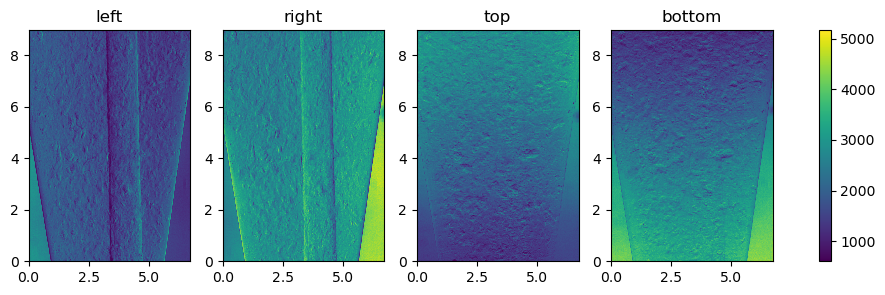

In [7]:
title_labels = ['left','right', 'top', 'bottom']
fig, axes = plt.subplots(1,4, figsize=(12,3))

vmin = np.min(phantom[projection])
vmax = np.max(phantom[projection])

print(vmin, vmax)

for i, ax in enumerate(axes.flat):
    im = ax.pcolormesh(X, Y, phantom[projection][i], vmin=vmin, vmax=vmax, cmap='viridis')
    ax.set_title(title_labels[i], fontsize=12)
    # ax[i].set_xlabel('Length (mm)')

# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(im, ax=axes.ravel().tolist())

# plt.suptitle('Raw images divided by background')

In [8]:
background = io.imread(img_dir + r'\2023-03-17 phase gradient background.tif').astype('float32')[0:]

def get_averaged_stack(im_stack, num_repeats):
    # Gets averaged image stack, assuming shape of image stack is (num_repeats * z_stack_depth, im_height, im_width)
    # num_repeats (int): number of averaged images
    # SIMILAR TO calibrations/lens_aperture.ipynb, but order is reversed
    num_repeats = int(num_repeats)

    dim_0, im_length, im_width = im_stack.shape
    reshaped = im_stack.reshape(num_repeats, dim_0//num_repeats, im_length, im_width)
    output = np.mean(reshaped, axis=0)
    return output

background = get_averaged_stack(background, 5)
# np.max(background[4])
# plt.imshow(background.reshape(5,4, 1392, 1040)[2,0,:,:])

Background
* Important to see that it is working correctly

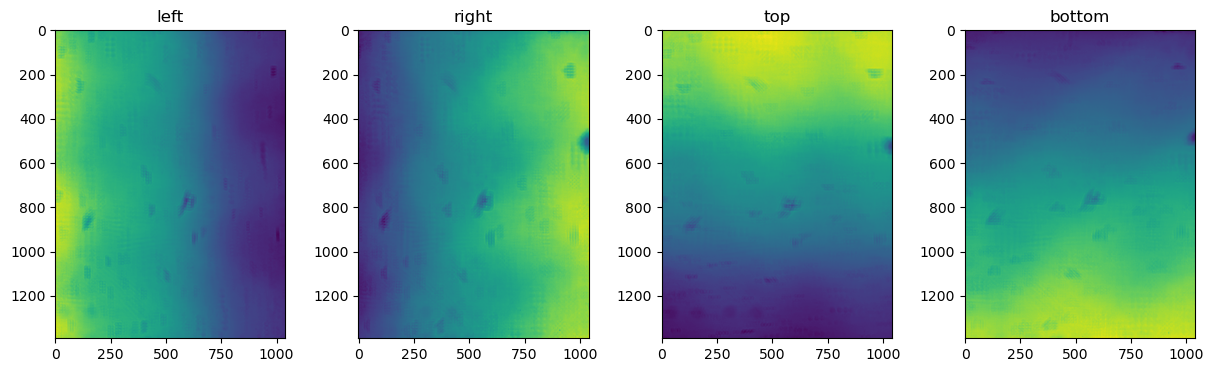

In [9]:
title_labels = ['left','right', 'top', 'bottom']
fig, ax = plt.subplots(1,4 ,figsize=(15, 4))
for i in range(4):
    ax[i].imshow(background[i])
    ax[i].set_title(title_labels[i])

Parthasarathy et al 2012 do not specify background subtraction. Background division seems logical?

In [10]:
#phantom -= background
phantom /= background

0.20354788 2.8426595


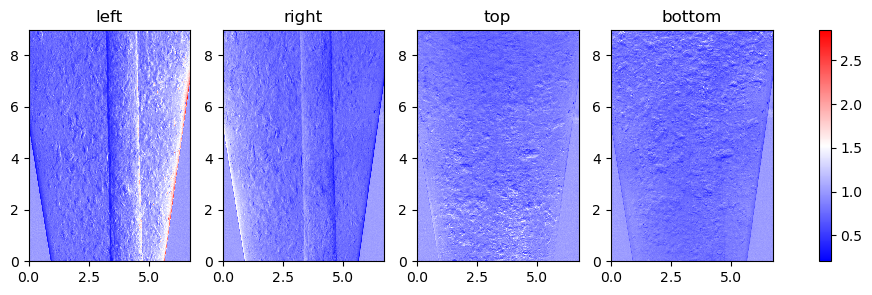

In [11]:
title_labels = ['left','right', 'top', 'bottom']
fig, axes = plt.subplots(1,4, figsize=(12,3))

vmin = np.min(phantom[projection])
vmax = np.max(phantom[projection])

print(vmin, vmax)

for i, ax in enumerate(axes.flat):
    im = ax.pcolormesh(X, Y, phantom[0][i], vmin=vmin, vmax=vmax, cmap='bwr')
    ax.set_title(title_labels[i], fontsize=12)
    # ax[i].set_xlabel('Length (mm)')

# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(im, ax=axes.ravel().tolist())

Left right DPC image

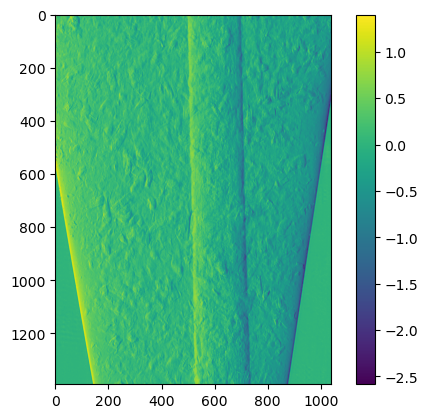

In [12]:
plt.imshow((phantom[projection,1,:,:] - phantom[projection,0,:,:]))
plt.colorbar()

Left right brightfield image

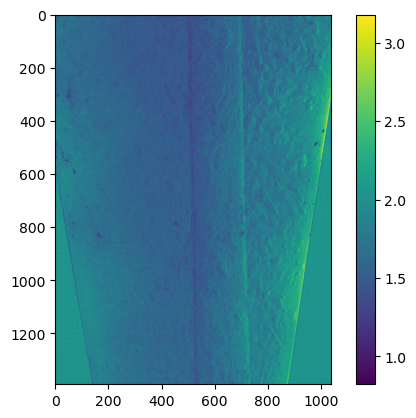

In [13]:
plt.imshow(np.sum(phantom[0,0:2,:,:], axis=(0)))
plt.colorbar()

Convert intensity images into wavefront tilt.

In [14]:
NA = 0.03 # Numerical aperture of f/d
lamb = 0.650 # in microns
factor = 2*np.pi/lamb*NA
left_right =  factor*(phantom[:,1,:,:] - phantom[:,0,:,:])/np.sum(phantom[:,0:2,:,:], axis=(1))
top_bottom = factor*(phantom[:,2,:,:] - phantom[:,3,:,:])/np.sum(phantom[:,2:,:,:], axis=(1))

In [15]:
raw_data_package = {'left_right':left_right[0], 
                    'top_bottom':top_bottom[0],
                    'phantom':phantom[0]}
import pickle
with open("2023-04-20 agarose-data_package.pkl", 'wb') as f:
    pickle.dump(raw_data_package, f)

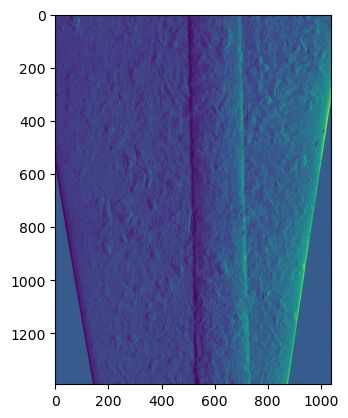

In [16]:
plt.imshow(raw_data_package['phantom'][0])

In [23]:
factor

0.28999316802367314

## Phase gradient

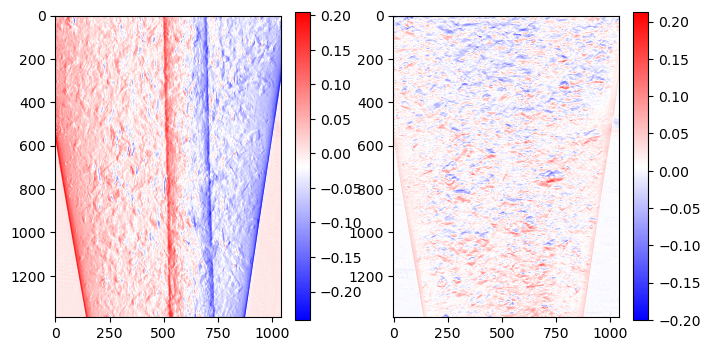

In [24]:
slice = 0
fig, ax = plt.subplots(1,2, figsize=(8,4))
lr_im = ax[0].imshow(left_right[slice], cmap='bwr')
plt.colorbar(lr_im)
tb_im = ax[1].imshow(top_bottom[slice], cmap='bwr')

plt.colorbar(tb_im)
# ax[0].imshow(np.average(phantom[slice], axis=0), cmap='gray')
# ax[0].set_title('brightfield (sum)')
# ax[0].axis('off')

### 2D Fourier integral method

$$ \Phi (x, y) = \mathcal{F}^{-1} [\frac{\mathcal{F}[\Phi_x + i \Phi_y](k, l)}{2\pi i (k + il)}](x, y) = \mathcal{F}^{-1} [\frac{\mathcal{F}[g](k, l)}{2\pi i (k + il)}](x, y) $$

Source: [A two-directional approach for grating based differential phase contrast imaging using hard X-rays](https://www.researchgate.net/publication/26297519_A_two-directional_approach_for_grating_based_differential_phase_contrast_imaging_using_hard_X-rays)

In [ ]:
# def fourier(image):
#     # Takes 2D Fourier transform of image
#     ft = np.fft.ifftshift(image)
#     ft = np.fft.fft2(ft)
#     ft = np.fft.fftshift(ft)
    
#     # freq_x = np.fft.fftfreq(ft.shape[0])
#     # freq_y = np.fft.fftfreq(ft.shape[1])
#     # freq_x = np.fft.fftshift(freq_x)
#     # freq_y = np.fft.fftshift(freq_y)

#     # plt.imshow(np.abs(ft), extent=(freq_x.min(),freq_x.max(),freq_y.min(),freq_y.max()))
#     # plt.colorbar()
#     # plt.xlabel('k')
#     # plt.ylabel('l')
#     # plt.show()
               
#     return ft# , (freq_x, freq_y)

# def inv_fourier(ft):
#     # Takes 2D inverse FT of image
#     ift = np.fft.ifftshift(ft)
#     ift = np.fft.ifft2(ift)
#     ift = np.fft.fftshift(ift)

#     return ift

# def do_fourier_integration(dphi_x, dphi_y, freq_x, freq_y):
#     # does Fourier integration of a 2D image
#     # given dphi_x (gradient in x direction)
#     # and dphi_y (gradient in y direction)
#     # small epsilon to prevent division by 0
#     eps = 5e-16
#     # integrate g
#     g = dphi_x + (1j * dphi_y)
#     ft_g = fourier(g)
#     # denominator of the fraction
#     freq_xx, freq_yy = np.meshgrid(freq_x, freq_y, indexing='ij')
#     denom = ((2. * np.pi * 1.0j) * (freq_xx + (1.0j * freq_yy))) + eps
#     phi = inv_fourier(ft_g / denom)
#     return np.imag(phi)

# freq_x = np.fft.fftfreq(im_height)
# freq_y = np.fft.fftfreq(im_width)
# freq_x = np.fft.fftshift(freq_x)
# freq_y = np.fft.fftshift(freq_y)

# initial = do_fourier_integration(left_right[0, :,:], top_bottom[0, :,:], freq_x, freq_y)
# plt.imshow(initial)
# phi = -(initial - np.max(initial) )* e*1e3 * im_width

Demonstrate this for 1 slice

Text(0.5, 1.0, 'phase contrast image (radians)')

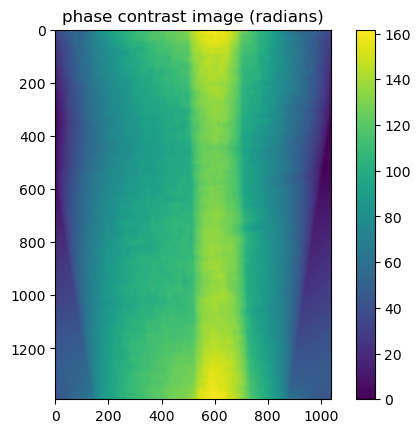

In [44]:
FT = lambda x: (np.fft.fft2(x))
IFT = lambda x: (np.fft.ifft2(x))

def do_fourier_integration(dphi_x, dphi_y, freq_x, freq_y):
    # does Fourier integration of a 2D image
    # given dphi_x (gradient in x direction)
    # and dphi_y (gradient in y direction)
    
    # integrate g
    g = dphi_x + (1j * dphi_y)
    ft_g = FT(g)
    # denominator of the fraction
    freq_xx, freq_yy = np.meshgrid(freq_x, freq_y, indexing='ij')
    denom = ((2. * np.pi) * (freq_xx + (1.0j * freq_yy))) 
    # plt.imshow(np.abs(np.fft.fftshift(denom)))
    # plt.show()

    # This prevents zero division (inadvertently sets mean of the reconstruction to be 0)
    divided = np.divide(ft_g, denom, out=np.zeros_like(ft_g), where=denom!=0)
    phi = IFT(divided)
    return np.imag(phi)

# Take slices
phi_x = left_right[0]
phi_y = top_bottom[0]

# Frequencies
freq_x = np.fft.fftfreq(im_height)
freq_y = np.fft.fftfreq(im_width)

integral_fourier = do_fourier_integration(phi_y, phi_x , freq_x, freq_y)
plt.imshow((integral_fourier -np.min(integral_fourier))*e*1e3)
plt.colorbar()

plt.title('phase contrast image (radians)')
# plt.axis('off')

Now altogether, do it for all the projections

In [49]:
num_projections = 400
phase_contrast = np.zeros((num_projections, im_height, im_width))

for i in tqdm(range(num_projections)):
    phi = do_fourier_integration(top_bottom[i], left_right[i], freq_x, freq_y)
    phase_contrast[i] = phi

100%|██████████| 400/400 [02:05<00:00,  3.19it/s]


Background testing

In [ ]:
# background.shape

(4, 1392, 1040)

In [ ]:
# NA = 0.03 # Numerical aperture of f/d
# lamb = 0.650 # in microns
# factor = 2*np.pi/lamb*NA
# left_right_bg = NA* (background[1] - background[0])/np.sum(background[0:2])
# top_bottom_bg = NA* (background[2] - background[3])/np.sum(background[2:])

# phi_bg = do_fourier_integration(left_right_bg, top_bottom_bg, freq_x, freq_y)
# plt.imshow(phi_bg*e*1e6*im_width)
# plt.colorbar()

In [ ]:
# left_right_bg = NA* (background[1]/background[1] - background[0]/background[0])/np.sum(background[0:2]/background[0:2])
# top_bottom_bg = NA* (background[2]/background[2] - background[3]/background[3])/np.sum(background[2:]/background[2:])

# phi_bg = do_fourier_integration(left_right_bg, top_bottom_bg, freq_x, freq_y)
# plt.imshow(phi_bg*e*1e6*im_width)
# plt.colorbar()

Scale the image by the pixel size $e$ in microns to match $k$ used.

In [50]:
del phantom

NameError: name 'phantom' is not defined

In [53]:
# phase_contrast_subtracted = (phase_contrast - np.array(means)[:,None,None])* e*1e6*im_width
phase_contrast_subtracted = (phase_contrast - np.min(phase_contrast, axis=(1,2))[:,None,None])* (e*1e3) 

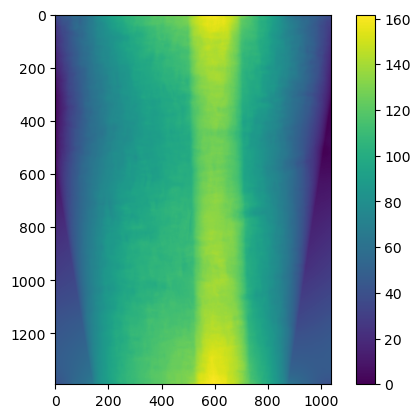

In [54]:
plt.imshow(phase_contrast_subtracted[0] )
plt.colorbar()

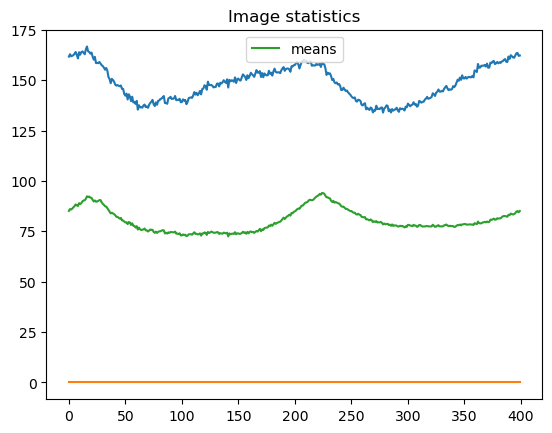

In [56]:
plt.title('Image statistics')
plt.plot(np.max(phase_contrast_subtracted, axis=(1,2)))
plt.plot(np.min(phase_contrast_subtracted, axis=(1,2)))
plt.plot(np.mean(phase_contrast_subtracted, axis=(1,2)), label='means')
plt.legend()
plt.show()
# plt.plot(std)

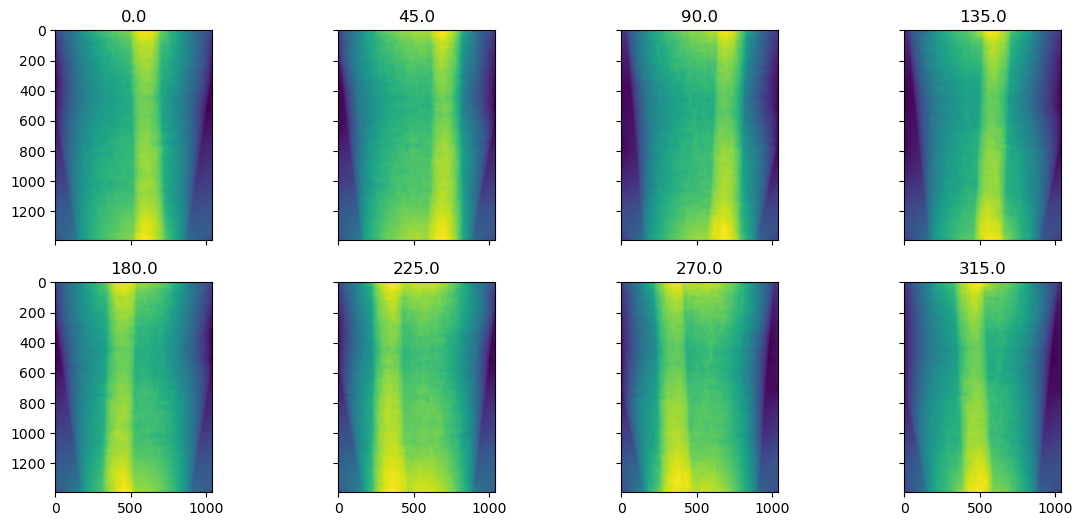

In [64]:
# for i in np.arange(0,400,50):
#     plt.imshow(phase_contrast_subtracted[i])
#     plt.colorbar()
#     plt.title('Reconstructed phase?')
#     plt.show()

fig, axes = plt.subplots(ncols=4,nrows=2, sharex=True, sharey=True, figsize=(14,6))

for i, ax in enumerate(axes.flat):
    index = i* 400/8
    ax.imshow(phase_contrast_subtracted[int(index)])
    ax.set_title(index/400*360)

plt.show()

In [65]:
import pickle
with open('2023-04-20 agarose-phantom-fourier.pkl', 'wb') as f:
    pickle.dump(phase_contrast_subtracted, f)

Save as tiff

In [ ]:
# io.imsave('2023-03-22 phase_contrast.tiff', ( phase_contrast_subtracted).astype('uint16') )